In [5]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
cmap = matplotlib.colormaps.get('tab10').colors
from gen_3D_dataset import ThreeDGraphDataset
import torch
import torch_geometric as tg
from tqdm import trange
import os
from scipy.spatial import KDTree

In [6]:
np.expand_dims(np.array([1,2,3]), axis=0)

array([[1, 2, 3]])

In [2]:
# Implementation of rotation in case some time needed
from scipy.spatial.transform import Rotation
def rotate_nodes(nodes, angle=np.array([0,0,0])):
    '''
    Rotate nodes by angle in degrees. Angle is a 3D vector with the angles in degrees for each axis, see extrinsic Euler angles.
    '''
    rot_mat = Rotation.from_euler('XYZ', angle, degrees=True).as_matrix()
    nodes = np.dot(rot_mat, nodes.T).T
    return nodes

In [3]:
def plot(nodes,cons=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(nodes[:,0], nodes[:,1], nodes[:,2], 'o', color=cmap[0])
    #ax.plot(m_rot[:,0], m_rot[:,1], m_rot[:,2], '+', color=cmap[1])
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    if cons is not None:
        for con in cons.T:
            # This for loop is necessary, 3d plotting is weird.
            ax.plot([nodes[con[0],0], nodes[con[1],0]], [nodes[con[0],1], nodes[con[1],1]], [nodes[con[0],2], nodes[con[1],2]], '-', color=cmap[1])
      
    ax.view_init(6, -80, 0)
    ax.set_aspect('equal')
    plt.show()

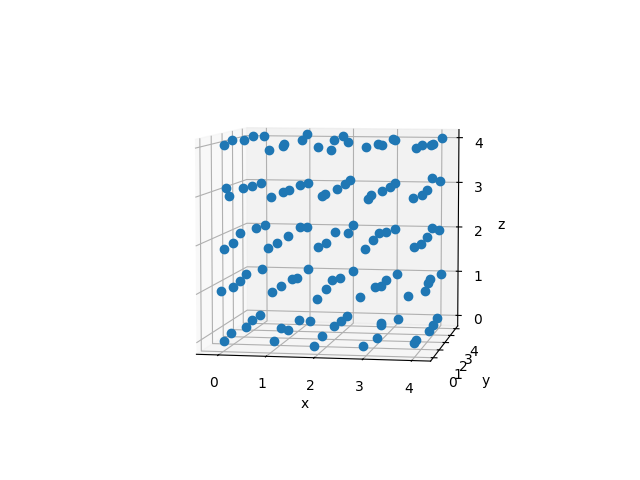

Data(x=[125, 1], edge_index=[2, 768], edge_attr=[768, 3], y=[1, 14], pos=[125, 3])

In [10]:
n = 30
dataset = ThreeDGraphDataset(root='3D_graphs', n_graphs_per_type=n)
#dataset.process()
train_loader = tg.loader.DataLoader(dataset[:n*12], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*12:], batch_size=16, shuffle=True)
edges =dataset[11].edge_index
nodes = dataset[11].pos
plot(nodes)
dataset[11]

In [11]:
in_shape = dataset[0].num_features
out_shape = dataset[0].y.shape[1]
class GINEConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GINEConv(torch.nn.Linear(in_shape, 10), edge_dim=3)
        self.conv2 = tg.nn.GINEConv(torch.nn.Linear(10, 20), edge_dim=3)
        self.conv3 = tg.nn.GINEConv(torch.nn.Linear(20, 30), edge_dim=3)
        self.classifier = torch.nn.Linear(30, out_shape)
    def forward(self, x, edge_index, edge_attr, batch):
        x = torch.tanh(self.conv1(x, edge_index, edge_attr))
        x = torch.tanh(self.conv2(x, edge_index, edge_attr))
        x = torch.tanh(self.conv3(x, edge_index, edge_attr))
        x = tg.nn.global_mean_pool(x, batch)
        x = self.classifier(x)
        #out = torch.nn.functional.softmax(x, dim=1) # Get rid of softmax if using CrossEntropyLoss
        out = x
        return out
model2 = GINEConv()
print(model2)

optimizer2 = torch.optim.NAdam(model2.parameters())
criterion2 = torch.nn.CrossEntropyLoss()

def train2(loader):
    model2.train()
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)# Perform a single forward pass.
        loss = criterion2(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer2.step()  # Update parameters based on gradients.
        optimizer2.zero_grad() # Reset grads.
def test2(loader):
    model2.eval()
    correct = 0
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)


GINEConv(
  (conv1): GINEConv(nn=Linear(in_features=1, out_features=10, bias=True))
  (conv2): GINEConv(nn=Linear(in_features=10, out_features=20, bias=True))
  (conv3): GINEConv(nn=Linear(in_features=20, out_features=30, bias=True))
  (classifier): Linear(in_features=30, out_features=14, bias=True)
)


In [12]:
accs = []
acc = test2(test_loader)
accs.append(acc)
for epoch in range(1, 30):
    train2(train_loader)
    test_acc = test2(test_loader)
    print(test_acc)
    accs.append(test_acc)
fig,ax = plt.subplots()
ax.plot(accs, label='GINEConv')
ax.legend()

KeyboardInterrupt: 

In [ ]:
np.savetxt('NN_results/accs_10-20-30-14_555graph.txt', accs)

In [4]:
class Test():
    def __init__(self):
        self.lattice_types ={
             0: {'name': 'aP', 'nodes': self._get_P_nodes, 'binding_angles': [  0,   0,   0], 'scale': [0, 0, 0], 'label': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
             1: {'name': 'mP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,   0,  90], 'scale': [0, 0, 0], 'label': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
             2: {'name': 'mS', 'nodes': self._get_S_nodes, 'binding_angles': [ 90,   0,  90], 'scale': [0, 0, 0], 'label': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
             3: {'name': 'oP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0], 'label': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
             4: {'name': 'oS', 'nodes': self._get_S_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0], 'label': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
             5: {'name': 'oI', 'nodes': self._get_I_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0], 'label': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]},
             6: {'name': 'oF', 'nodes': self._get_F_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0], 'label': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]},
             7: {'name': 'tP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 0], 'label': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]},
             8: {'name': 'tI', 'nodes': self._get_I_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 0], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]},
             9: {'name': 'hR', 'nodes': self._get_P_nodes, 'binding_angles': [  0,   0,   0], 'scale': [1, 1, 1], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]},
            10: {'name': 'hP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90, 120], 'scale': [1, 1, 0], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]},
            11: {'name': 'cP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 1], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]},
            12: {'name': 'cI', 'nodes': self._get_I_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 1], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]},
            13: {'name': 'cF', 'nodes': self._get_F_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 1], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]},
        }
        self.size=(3,3,3)
        self.con_length = 1.5
        self.apply_noise = True
    
    def process(self, lattice_type: int):
        pos, edge_index, label = self._process_lattice(self.lattice_types[lattice_type])
        node_attr = self._get_node_attr(pos, edge_index)
        edge_attr = self._get_edge_attr(pos, edge_index)
        return pos, edge_index, node_attr, edge_attr, label
    
    # Changes:
    
    def _get_P_nodes(self, angles=np.array([90,90,90])):
        '''
        Get the nodes of a primitive lattice.
        '''
        scaling = np.sin(np.radians(angles))
        vec1 = np.arange(0,self.size[0],1)
        vec2 = np.arange(0,self.size[1]*scaling[2],1*scaling[2])
        vec3 = np.arange(0,self.size[2]*scaling[1],1*scaling[1])
        a, b, c = np.meshgrid(vec1,vec2, vec3)
        nodes = np.stack([a,b,c],axis=-1) # Stack them in a new axis
        nodes = np.reshape(nodes, (-1, 3)) # Reshape to an arr of nodes with shape (#nodes, 3)
        return nodes

    def _get_S_nodes(self):
        '''
        Get the nodes of a base-centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + np.array([0.5,0.5,0])
        return np.append(P,extra,axis=0)

    def _get_I_nodes(self):
        '''
        Get the nodes of a body-centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + 0.5
        return np.append(P,extra,axis=0)

    def _get_F_nodes(self):
        '''
        Get the nodes of a face-centred lattice.
        '''
        P = self._get_P_nodes()
        extra1 = P + np.array([0.5,0.5,0])
        extra2 = P + np.array([0,0.5,0.5])
        extra3 = P + np.array([0.5,0,0.5])
        return np.row_stack((P, extra1, extra2, extra3))
    

    def _process_lattice(self, arg_dict):
        '''
        Method that processes a lattice of a given type. The method is called with a dictionary holding parameters for one of the lattice types. It contains the following keys:
            - name: The name of the lattice type
            - nodes: The method to get the fitting fundamental lattice nodes
            - binding_angles: A list of binding angles [alpha, beta, gamma] of the lattice type. Angles are in degrees. 0° means to generate a independent random angle (0,180)°
            - scale: A list of scaling factors [x,y,z] for the lattice type. 0 means to generate a random scaling factor (0,2)
            - label: One hot encoded label for the lattice type
        '''
        # Get lattice angles
        angles = np.array(arg_dict['binding_angles'])
        if arg_dict['name'] == 'hR':
            # Special case for hR lattice as it has 3 identical but random angles
            angles = np.where(angles == 0, rng.uniform(46,89,1), angles)
        else:
            angles = np.where(angles == 0, rng.uniform(46,89,3), angles)
            
        # Get the fundamental lattice nodes
        if arg_dict['name'] in ['hR', 'hP']:
            # For hR and hP lattices we need to give the angles to the nodes method so that sheared connections are equally long
            nodes = arg_dict['nodes'](angles)
        else:
            nodes = arg_dict['nodes']()
        nodes = self._shear_nodes(nodes, angles)
        # Find random scale and apply gaussian noise to the lattice accordingly
        scale = np.array(arg_dict['scale'])
        scale = np.where(scale == 0, rng.uniform(0.1,3,3), scale)
        noise_level = 0.05 / scale  # At this step we scale the noise down, so that the scaling later on does not affect the noise level
        if self.apply_noise:
            nodes += rng.normal(0, noise_level, nodes.shape)
        # Find the connections between the nodes in a given radius
        cons= self._get_cons_in_radius(nodes, self.con_length+np.mean(noise_level))
        # Apply the saved scaling
        #nodes *= scale
        
        # Add defects to the lattice
        #nodes, cons = self._add_defects(nodes, cons)
        return nodes, cons, np.array([arg_dict['label']])

    def _get_cons_in_radius(self, nodes, radius):
        '''
        Get the connections in a radius as well as the total number of cons for each node.
        '''
        tree = KDTree(nodes)
        cons = tree.query_pairs(radius, output_type='ndarray', p=2)
        cons = cons.T
        cons = np.column_stack((cons, cons[::-1])) # Add the reverse connections
        return cons

    def _shear_nodes(self, nodes, binding_angle):
        '''
        Shear nodes. Binding angle is a 3D vector with the Binding angle in each axis.
        '''
        delta = np.tan(np.radians(np.array(binding_angle)))
        assert not np.any(delta == 0), 'Binding angle cannot be 0'
        nodes = nodes.astype(float)
        nodes = nodes + np.stack((nodes[:,2]/delta[0] + nodes[:,1]/delta[2], nodes[:,2]/delta[1] , np.zeros_like(nodes[:,1])), axis=1)
        return nodes

    def _add_defects(self, nodes, edge_index):
        '''
        Method that adds up to 10% of random defects (i.e. missing nodes) to the lattice. Should be called after _get_*_graph() but before
        _get_edge_attr() and _get_node_attr().
        '''
        # Draw up to 10% of unique random indices for nodes to be removed
        drop_indices = rng.choice(np.arange(len(nodes)), rng.integers(len(nodes)//10), replace=False)
        # Remove the nodes
        nodes = np.delete(nodes, drop_indices, axis=0)
        # Delete every connection that refers to a removed node
        edge_index = np.delete(edge_index, np.where(np.isin(edge_index, drop_indices))[1], axis=1)
        
        # As edge_index refers to the original node indices, we need to adjust the indices of most connections
        # For this we create a mapping from old indices to new indices
        old_to_new = np.arange(len(nodes) + len(drop_indices))  # Start with an array of original indices; [0,1,2,3,4,5,...]
        old_to_new[drop_indices] = -1  # Mark the indices of the nodes to be deleted; eg. drop_indices = [1,3] -> [0,-1,2,-1,4,5,...]
        old_to_new = np.cumsum(old_to_new != -1) - 1  # Create a cumulative sum array; cumsum([True, False, True, False, True, True,...]) -1 -> [1,1,2,2,3,4,...] -1 -> [0,0,1,1,2,3,...]
        
        # # Update edge indices to reflect new node indices through broadcasting magic
        edge_index = old_to_new[edge_index]
        return nodes, edge_index
        
    def _get_node_attr(self,nodes,cons):
        '''
        Method that returns the node attributes for each node in the graph. Should be called after creating the graph and adding defects.
        Returns an array of shape (len(pos) = #Nodes) with the entries [C] for each node.
            - C: Number of connections to other nodes
        '''
        # Get the number of connections for each node
        connection_counts = np.zeros(len(nodes))
        for edge in cons[0]:
            # Iterate over all edge start points and count the connections for each node. Start points sufficient, as connections are bidirectional.
            connection_counts[edge] += 1 
            
        return np.expand_dims(connection_counts, axis=1)
    
    def _get_edge_attr(self,nodes,cons):
        '''
        Method that returns the edge attributes for each edge in the graph. Should be called after creating the graph and adding defects.
        Returns an array of shape (len(edge_index[0])= #Edges, 2) with the entries [dx,dy] for each edge.
        '''
        # Get the edge vectors for each edge
        edge_vectors = nodes[cons[0]] - nodes[cons[1]]
        return edge_vectors
    

In [5]:
import ipywidgets as widgets
from ipywidgets.widgets import interact
from IPython.display import display
w =widgets.ToggleButtons(
    options=range(14),
    description='Graph type:',
    disabled=False,
    tooltips=['aP','mP','mS','oP','oS','oI','oF','tP','tI','hR','hP','cP','cI','cF']
)
w2=widgets.FloatSlider(
    value=1.2,
    min=0.5,
    max=2,
    step=0.1,
    description='Connection length:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
w3 = widgets.Checkbox(
    value=False,
    description='Apply noise',
    disabled=False
)
def f(x,y,z):
    graph = Test()
    graph.apply_noise = z
    graph.size = (3,3,2)
    graph.con_length = y
    pos, cons, _,_,_  = graph.process(x)
    plt.close('all')
    plot(pos, cons)

interact(f, x=w, y=w2,z=w3)

interactive(children=(ToggleButtons(description='Graph type:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …

<function __main__.f(x, y, z)>

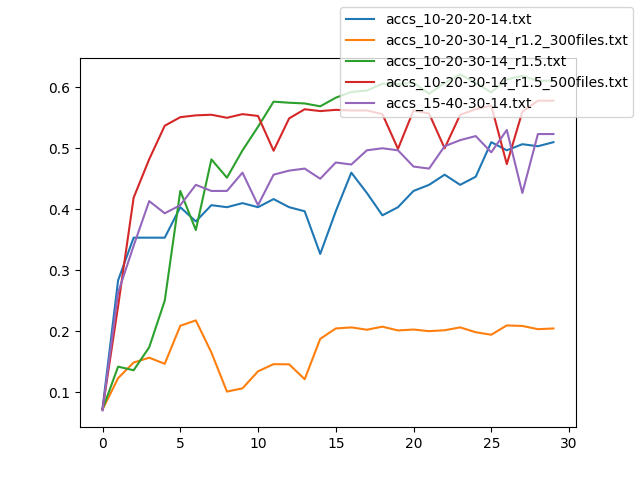

In [8]:
import os 
base = 'NN_results'
files = os.listdir(base)
fig,ax = plt.subplots()
for file in files:
    accs = np.loadtxt(os.path.join(base, file))
    ax.plot(accs, label=file)
fig.legend()

In [ ]:
0.6895
0.7873333333333333
0.8411666666666666
0.8561666666666666
0.8795
0.9003333333333333
0.895
0.9101666666666667
0.9148333333333334
0.9111666666666667
0.9096666666666666
0.9233333333333333
0.9231666666666667
0.9255
0.9291666666666667
0.9305
0.9298333333333333
0.9325
0.9361666666666667
0.922